In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from SpectralSVR import (
    Burgers,
    FourierBasis,
    to_complex_coeff,
    to_real_coeff,
    StandardScaler,
    SpectralSVR,
    Basis,
    LSSVR,
    FNN,
    get_metrics,
    resize_modes,
)
from notebooks.utils import save_to_pgf
from scipy.integrate import odeint as spo
from torchdiffeq import odeint as tdo
import numpy as np

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)

In [3]:
def get_function_values(u: Basis, f: Basis, res: tuple[slice, slice]):
    # get values at time resolution

    u_val, grid = u.get_values_and_grid(res=res)
    f_val = f.get_values(res=res)
    return u_val.real, f_val.real, grid


def get_time_dep_coeffs(
    u_val: torch.Tensor,
    f_val: torch.Tensor,
    target_modes: int | tuple[int, ...] | None = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    # get the coefficients at each time step
    sample_time_shape = f_val.shape[:2]
    u_coeff = FourierBasis.transform(u_val.flatten(0, 1))
    f_coeff = FourierBasis.transform(f_val.flatten(0, 1))
    if target_modes is not None:
        u_coeff = resize_modes(u_coeff, target_modes=target_modes)
        f_coeff = resize_modes(f_coeff, target_modes=target_modes)
    u_coeff = u_coeff.unflatten(0, sample_time_shape)
    f_coeff = f_coeff.unflatten(0, sample_time_shape)
    return u_coeff, f_coeff


# input data shape = (sample_number, time, space)
# output data shape = (sample_number, time-1, space)
def get_time_pairs(
    u_val: torch.Tensor,
    f_val: torch.Tensor,
):
    # current time step
    uc = u_val[:, :-1]
    fc = f_val[:, :-1]
    # future time step
    uf = u_val[:, 1:]
    return uc, fc, uf


# feature (sample_number*(time-1), space*2) the times 2 is from the concatenation of solution and forcing term
# label (sample_number*(time-1), space)
def get_features_labels(
    uc: torch.Tensor,
    fc: torch.Tensor,
    uf: torch.Tensor,
    sample_size=-1,
    generator=None,
):
    x = to_real_coeff(torch.concat((uc, fc), dim=2).flatten(0, 1))
    # x = uc_flat
    y = (uf - uc).flatten(0, 1)
    if sample_size >= 0 and sample_size < len(x):
        sample_size = min(len(x), sample_size)
        sample_index = torch.randperm(sample_size, generator=generator)[:sample_size]
        x = x[sample_index]
        y = y[sample_index]
    return x, y

In [4]:
def u_exact(x: torch.Tensor, t: torch.Tensor, nu: float = 0.01, c: float = 2.0):
    # use p. 705-706 Partial Differential Equations and Solitary Waves Theory, Abdul-Majid Wazwaz
    # eq 1.5 doi: 10.1090/QAM/306736
    # doi: 10.1002/cnm.850
    if t.ndim == 1:
        t = t.unsqueeze(1)
    pi = torch.pi
    pi_x = pi * x
    u = (2 * nu * pi * pi_x.sin()) / (c * t.mul(pi**2 * nu).exp() + pi_x.cos())
    return u


def get_tdo_rollout(
    u_init: torch.Tensor,  # function values
    f: FourierBasis,
    nu: float,
    tt: torch.Tensor,
    space_res: slice,
):
    # fc_np = fc.numpy()

    x = FourierBasis.grid(
        res=space_res
    ).flatten(
        0, -2
    )  # transform to list of coordinates (flatten all dims except coordinate which is the last)
    dx = x[1, 0].sub(x[0, 0]).item()
    x = x.tile((1, 2))  # expand the coordinate to be 2 coordinates

    def f_func(t: float):
        x[:, 0] = t
        return f(x).real.reshape((-1, u_init.shape[1]))

    def rhs_func(t: float, y0: torch.Tensor):
        u_val = y0  # unflatten to multiple samples
        ux = torch.gradient(u_val, spacing=dx, dim=1, edge_order=2)[0]
        uxx = torch.gradient(ux, spacing=dx, dim=1, edge_order=2)[0]
        uux = torch.gradient(u_val ** (2) * (0.5), spacing=dx, dim=1, edge_order=2)[0]

        # idx = int((t - tt[0]) * len(tt) / (tt[-1] - tt[0]))
        # ut = -uux + nu * uxx + fc_np[idx]
        ut = -uux + nu * uxx + f_func(t)
        return ut

    u_num = tdo(
        # rhs_func, u_init, tt, method="scipy_solver", options={"solver": "LSODA"}
        # rhs_func, u_init, tt, method="dopri8", options={"min_step": 0.001}
        rhs_func,
        u_init,
        tt,
        method="implicit_adams",
        options={"max_iters": 40},
    ).movedim(1, 0)
    return u_num


def get_spo_rollout(

    u_init: torch.Tensor,  # function values
    f: FourierBasis,
    nu: float,
    tt: torch.Tensor,
    space_res: slice,
):
    # fc_np = fc.numpy()

    x = FourierBasis.grid(
        res=space_res
    ).flatten(
        0, -2
    )  # transform to list of coordinates (flatten all dims except coordinate which is the last)
    dx = x[1, 0].sub(x[0, 0]).item()
    x = x.tile((1, 2))  # expand the coordinate to be 2 coordinates

    def f_func(t: float):
        x[:, 0] = t
        return f(x).real.reshape((-1, u_init.shape[1])).numpy()

    def rhs_func(t: float, y0: np.ndarray):
        u_val = y0.reshape(u_init.shape)  # unflatten to multiple samples
        ux = np.gradient(u_val, dx, axis=1, edge_order=2)
        uxx = np.gradient(ux, dx, axis=1, edge_order=2)
        uux = np.gradient(u_val ** (2) * (0.5), dx, axis=1, edge_order=2)

        # idx = int((t - tt[0]) * len(tt) / (tt[-1] - tt[0]))
        # ut = -uux + nu * uxx + fc_np[idx]
        ut = -uux + nu * uxx + f_func(t)
        return ut.flatten()

    # ode_object = spi(
    #     rhs_func,
    #     (tt[0].item(), tt[-1].item()),
    #     u_init.flatten().numpy(),
    #     method="BDF",
    #     t_eval=tt.numpy(),
    # )
    u_num = (
        # torch.tensor(ode_object.y).unflatten(0, (u_init.shape)).movedim(-1, 1)
        torch.tensor(spo(rhs_func, u_init.flatten().numpy(), tt.numpy(), tfirst=True))
        .unflatten(1, (u_init.shape))
        .movedim(1, 0)
    )
    return u_num


def get_model_rollout(
    model: SpectralSVR,
    u_init: torch.Tensor,  # function basis time dependent coefficients
    fh: torch.Tensor,
    spatial_res: slice,
    spatial_period: float,
    scaler: StandardScaler,
    # uh_temp: torch.Tensor,
) -> torch.Tensor:
    # fig, ax = plt.subplots()
    # im = ax.imshow(
    #     FourierBasis.inv_transform(to_complex_coeff(x_exact[:, :modes2])).real,
    #     aspect="auto",
    # )
    # fig.colorbar(im, ax=ax)

    uhc_list = []
    uhc = u_init  # initial condition
    uhc_list.append(uhc)
    fhc = fh[:, 0]
    for i in range(1, fh.shape[1]):
        xc = to_real_coeff(torch.cat((uhc, fhc), dim=1))
        duhf = model.regressor.predict(scaler.transform(xc))
        uhc = uhc + to_complex_coeff(duhf)  # next "initial" condition
        # uhc = uh_temp[:, i]
        uhc_list.append(uhc)
        fhc = fh[:, i]  # next forcing term

    uh_pred = torch.stack(uhc_list, dim=1)

    u_pred = (
        FourierBasis.inv_transform(
            uh_pred.flatten(0, 1),  # time dependent coeff inv transform
            res=spatial_res,
            periods=spatial_period,
        )
        .unflatten(0, uh_pred.shape[:2])
        .real
    )
    return u_pred


def plot_rollout(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    nu: float,
    time_res: slice,
    spatial_res: slice,
    label: str,
    n: int = -1,
):
    # compute metrics
    metrics = get_metrics(
        u_pred.flatten(1), u_target.flatten(1)
    )  # flatten because pointwise metrics like r2 want it in matrix form
    u_target = u_target[n]
    u_pred = u_pred[n]

    # vmax = max(u_target.max().item(), u_pred.max().item())
    # vmin = min(u_target.min().item(), u_pred.min().item())
    # symetric vlim
    vlim = max(abs(u_target.max().item()), abs(u_target.min().item()))
    vmax = vlim
    vmin = -vlim
    extent = (
        spatial_res.start,
        spatial_res.stop,
        time_res.start,
        time_res.stop,
    )
    xlim = (
        spatial_res.start,
        spatial_res.stop,
    )
    ylim = (
        time_res.start,
        time_res.stop,
    )

    # pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_pred,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_pred_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)
    # target
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_target,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_target_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)
    # diff
    diff = u_target - u_pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        diff,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_diff_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)

    return metrics

In [5]:
# def get_input_output(
#     u: Basis, f: Basis, time_res: slice, sample_size=-1, generator=None
# ):
#     # get values at time resolution
#     spatial_modes = u.to_time_dependent().modes[0]
#     spatial_res = slice(0, u.periods[1], spatial_modes)
#     res = (time_res, spatial_res)

#     u_val = u.get_values(res=res).real
#     # ut_val = u.grad(0).get_values(res=res)
#     f_val = f.get_values(res=res).real
#     # get the coefficients at the time resolution
#     u_coeff = FourierBasis.transform(u_val.flatten(0, 1)).unflatten(0, u_val.shape[:2])
#     # ut_coeff = u.transform(ut_val.flatten(0, 1)).unflatten(0, ut_val.shape[:2])
#     f_coeff = FourierBasis.transform(f_val.flatten(0, 1)).unflatten(0, f_val.shape[:2])
#     # merge sample and time dimension
#     # future time step diff
#     # dun = ut_coeff[:, 1:].flatten(0, 1)
#     dun = (u_coeff[:, 1:] - u_coeff[:, :-1]).flatten(0, 1)
#     # current time step
#     uc = u_coeff[:, :-1].flatten(0, 1)
#     fn = f_coeff[:, :-1].flatten(0, 1)
#     # merge all spatial coefficient dimensions and convert to real valued coefficients
#     uc_flat = to_real_coeff(uc.flatten(1))
#     fn_flat = to_real_coeff(fn.flatten(1))
#     x = torch.concat((uc_flat, fn_flat), dim=1)
#     # x = uc_flat
#     y = dun
#     if sample_size >= 0 and sample_size < len(x):
#         sample_size = min(len(x), sample_size)
#         sample_index = torch.randperm(sample_size, generator=generator)[:sample_size]
#         x = x[sample_index]
#         y = y[sample_index]
#     return x, y


# # def get_rollout(
# #     model: SpectralSVR,
# #     u: Basis,
# #     f: Basis,
# #     time_res: slice,
# #     scaler: StandardScaler,
# # ):
# #     x_exact, y_exact = get_input_output(u, f, time_res)
# #     modes2 = y_exact.shape[1] * 2
# #     # fig, ax = plt.subplots()
# #     # im = ax.imshow(
# #     #     FourierBasis.inv_transform(to_complex_coeff(x_exact[:, :modes2])).real,
# #     #     aspect="auto",
# #     # )
# #     # fig.colorbar(im, ax=ax)
# #     f_exact = x_exact[:, modes2:]
# #     u_init = x_exact[0:1, :modes2]
# #     y_pred = []
# #     uc = u_init
# #     y_pred.append(uc)
# #     fc = f_exact[0:1]
# #     # xc = x_exact[0:1]
# #     xc = torch.cat((uc, fc), dim=1)
# #     # dt = (time_res.stop - time_res.start) / (time_res.step - 1)
# #     for i in range(1, time_res.step - 1):
# #         duf = model.svr.predict(scaler.transform(xc))
# #         uc = uc + duf
# #         y_pred.append(uc)
# #         fc = f_exact[i : i + 1]
# #         xc = torch.cat((uc, fc), dim=1)
# #         # uc = x_exact[i : i + 1]
# #     duf = model.svr.predict(scaler.transform(xc))
# #     uc = uc + duf
# #     y_pred.append(uc)

# #     y_pred = to_complex_coeff(torch.cat(y_pred, dim=0))
# #     y_exact = to_complex_coeff(y_exact)

# #     # u_init = to_complex_coeff(x_exact[0:1, :modes2])
# #     u_pred = y_pred  # .cumsum(0)# + u_init
# #     # y_pred = torch.cat((u_init, u_pred), dim=0)
# #     u_target = y_exact.cumsum(0) + to_complex_coeff(u_init)
# #     # y_target = torch.cat((u_init, u_target), dim=0)
# #     return u_pred, u_target


# def get_old_rollout(
#     model: SpectralSVR,
#     u: Basis,
#     f: Basis,
#     time_res: slice,
#     scaler: StandardScaler,
# ):
#     x_exact, y_exact = get_input_output(u, f, time_res)
#     modes2 = y_exact.shape[1] * 2
#     # fig, ax = plt.subplots()
#     # im = ax.imshow(
#     #     FourierBasis.inv_transform(to_complex_coeff(x_exact[:, :modes2])).real,
#     #     aspect="auto",
#     # )
#     # fig.colorbar(im, ax=ax)
#     f_exact = x_exact[:, modes2:]
#     u_init = x_exact[0:1, :modes2]
#     y_pred = []
#     uc = u_init
#     fc = f_exact[0:1]
#     xc = x_exact[0:1]
#     # dt = (time_res.stop - time_res.start) / (time_res.step - 1)
#     y_pred.append(uc)
#     for i in range(1, time_res.step - 1):
#         duf = model.svr.predict(scaler.transform(xc))
#         uc = uc + duf
#         fc = f_exact[i : i + 1]
#         xc = torch.cat((uc, fc), dim=1)
#         # uc = x_exact[i : i + 1]
#         y_pred.append(uc)

#     y_pred = to_complex_coeff(torch.cat(y_pred, dim=0))
#     y_exact = to_complex_coeff(y_exact)

#     u_init = to_complex_coeff(x_exact[0:1, :modes2])
#     u_pred = y_pred  # .cumsum(0)# + u_init
#     # y_pred = torch.cat((u_init, u_pred), dim=0)
#     u_target = y_exact.cumsum(0) + u_init
#     # y_target = torch.cat((u_init, u_target), dim=0)
#     return u_pred, u_target


# def plot_model_rollout(
#     model: SpectralSVR,
#     u: Basis,
#     f: Basis,
#     time_res: slice,
#     spatial_res: slice,
#     scaler: StandardScaler,
#     nu: float,
#     label: str,
# ):
#     u_pred, u_target = get_old_rollout(model, u[0], f[0], time_res, scaler)

#     spectral_metrics = get_metrics(
#         to_real_coeff(u_pred),
#         to_real_coeff(u_target),
#     )

#     u_pred = FourierBasis.inv_transform(
#         to_complex_coeff(u_pred), res=(spatial_res,)
#     ).real
#     u_target = FourierBasis.inv_transform(
#         to_complex_coeff(u_target), res=(spatial_res,)
#     ).real

#     function_metrics = get_metrics(u_pred, u_target)
#     vmax = max(u_pred.max().item(), u_target.max().item())
#     vmin = min(u_pred.min().item(), u_target.min().item())
#     # symetric vlim
#     vlim = max(abs(vmax), abs(vmin))
#     vmax = vlim
#     vmin = -vlim
#     extent = (
#         spatial_res.start,
#         spatial_res.stop,
#         time_res.start,
#         time_res.stop,
#     )
#     xlim = (
#         spatial_res.start,
#         spatial_res.stop,
#     )
#     ylim = (
#         time_res.start,
#         time_res.stop,
#     )

#     # pred
#     fig, ax = plt.subplots(figsize=(3, 2))
#     im = ax.imshow(
#         u_pred,
#         aspect="auto",
#         vmin=vmin,
#         vmax=vmax,
#         extent=extent,
#         origin="lower",
#         interpolation="none",
#     )
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_ylabel("Time")
#     ax.set_xlabel("Space")
#     fig.colorbar(im, ax=ax)
#     save_to_pgf(f"burgers_{label}_pred_{nu}.pgf", plt=fig)
#     # target
#     fig, ax = plt.subplots(figsize=(3, 2))
#     im = ax.imshow(
#         u_target,
#         aspect="auto",
#         vmin=vmin,
#         vmax=vmax,
#         extent=extent,
#         origin="lower",
#         interpolation="none",
#     )
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_ylabel("Time")
#     ax.set_xlabel("Space")
#     fig.colorbar(im, ax=ax)
#     save_to_pgf(f"burgers_{label}_target_{nu}.pgf", plt=fig)
#     # diff
#     diff = u_target - u_pred
#     fig, ax = plt.subplots(figsize=(3, 2))
#     im = ax.imshow(
#         diff,
#         aspect="auto",
#         vmin=vmin,
#         vmax=vmax,
#         extent=extent,
#         origin="lower",
#         interpolation="none",
#     )
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_ylabel("Time")
#     ax.set_xlabel("Space")
#     fig.colorbar(im, ax=ax)
#     save_to_pgf(f"burgers_{label}_diff_{nu}.pgf", plt=fig)

#     return (spectral_metrics, function_metrics)

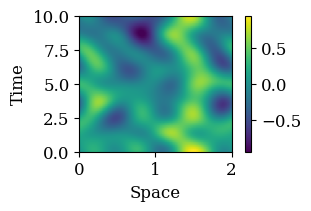

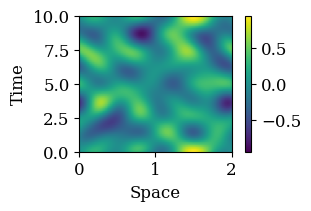

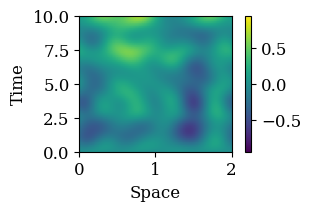

c:\Users\ahmad\AppData\Local\pypoetry\Cache\virtualenvs\skripsi-program-7DNU0s2h-py3.10\lib\site-packages\matplotlib\colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


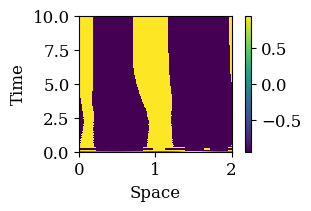

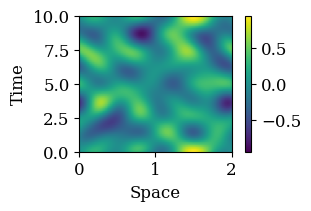

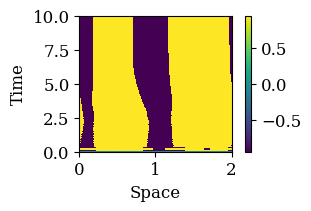

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16604\538213567.py:99: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  torch.tensor(spo(rhs_func, u_init.flatten().numpy(), tt.numpy(), tfirst=True))
c:\Users\ahmad\AppData\Local\pypoetry\Cache\virtualenvs\skripsi-program-7DNU0s2h-py3.10\lib\site-packages\matplotlib\colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\ahmad\AppData\Local\pypoetry\Cache\virtualenvs\skripsi-program-7DNU0s2h-py3.10\lib\site-packages\matplotlib\image.py:484: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


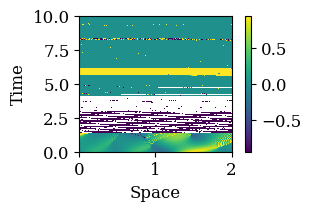

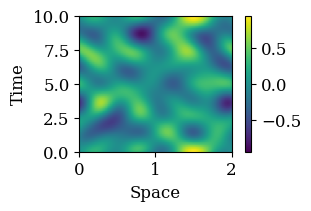

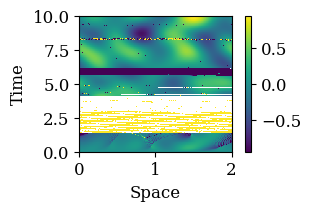

c:\Users\ahmad\AppData\Local\pypoetry\Cache\virtualenvs\skripsi-program-7DNU0s2h-py3.10\lib\site-packages\torchdiffeq\_impl\fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


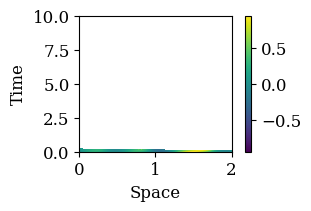

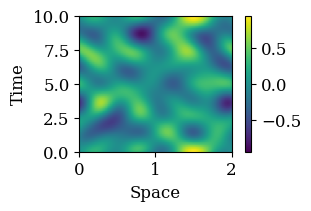

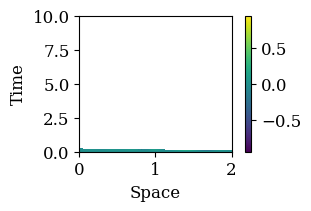

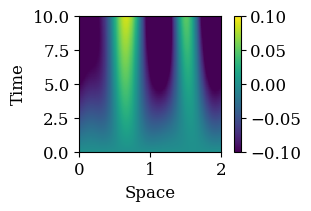

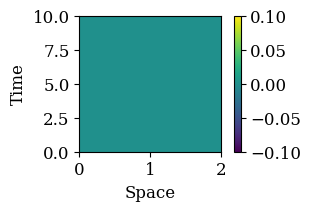

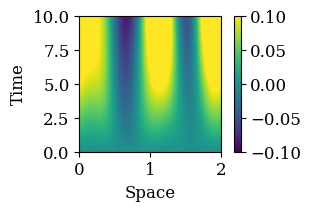

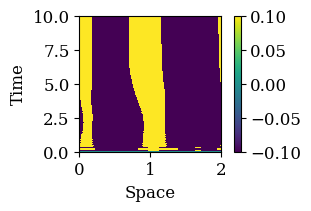

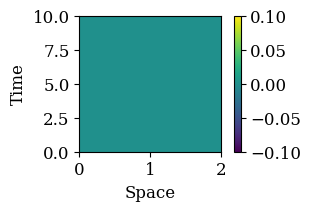

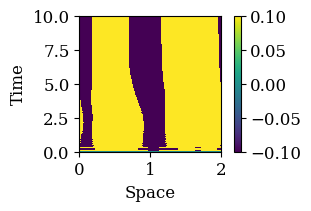

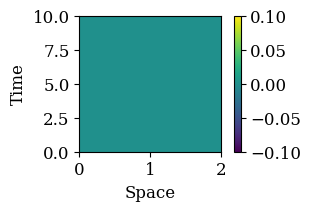

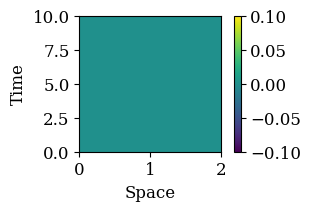

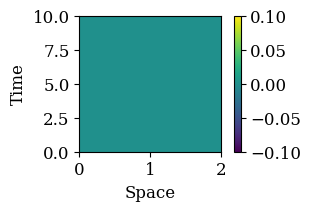

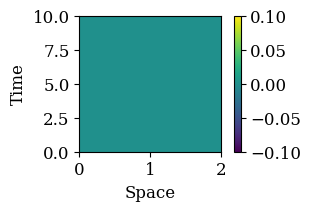

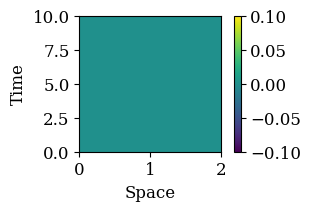

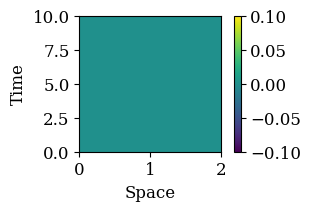

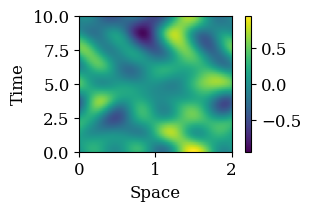

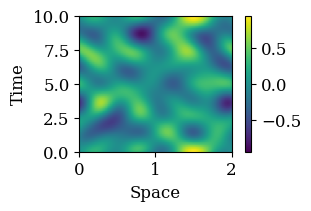

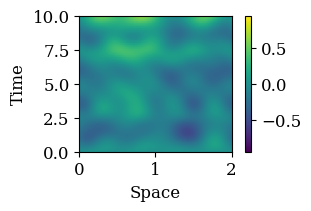

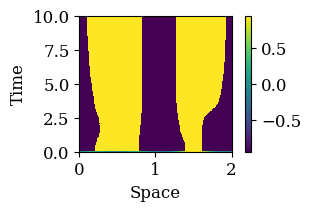

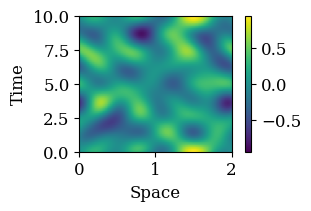

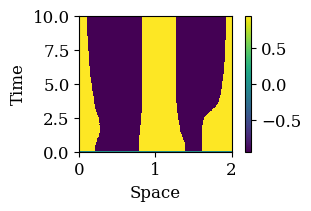

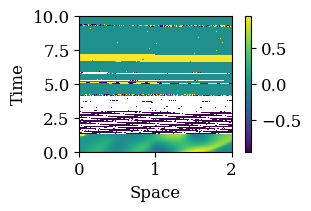

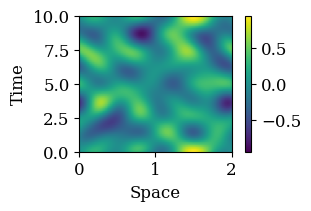

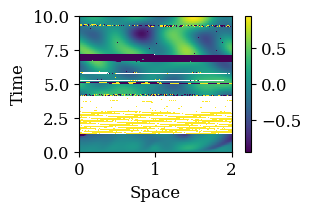

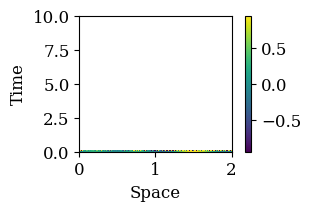

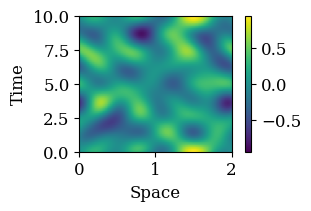

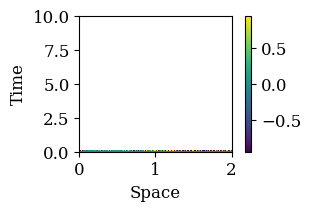

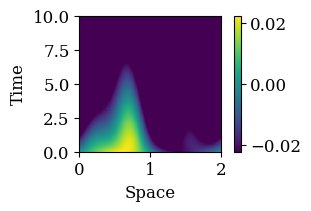

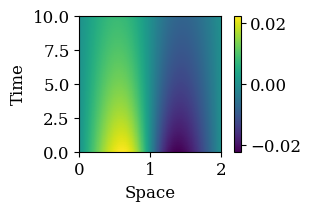

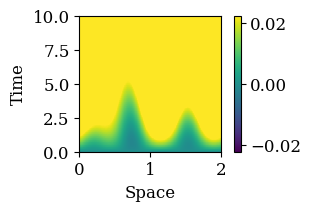

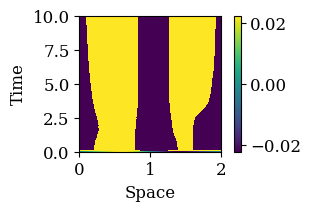

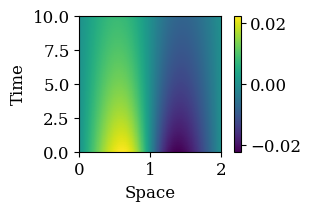

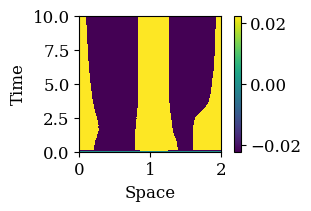

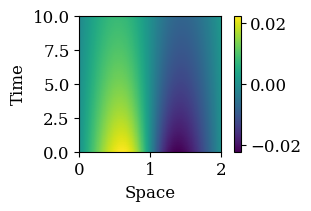

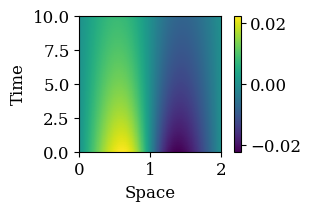

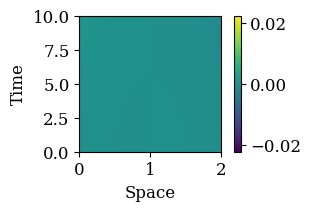

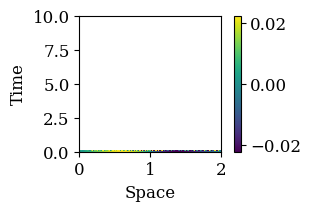

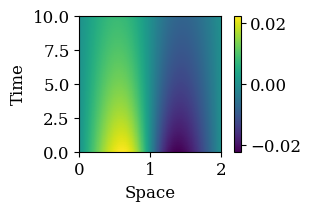

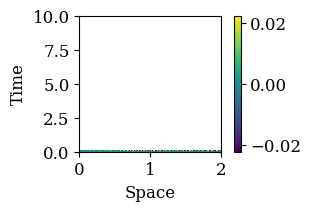

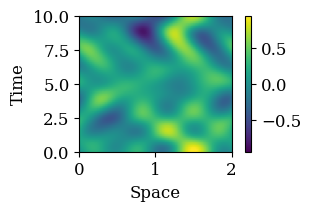

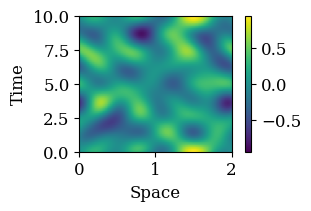

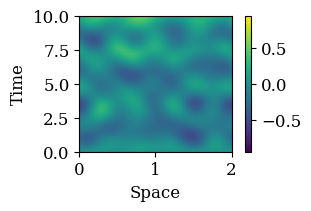

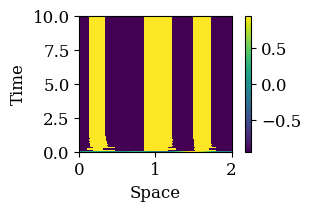

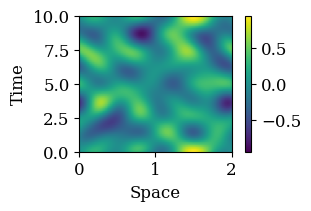

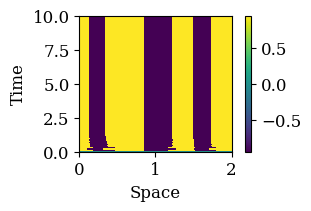

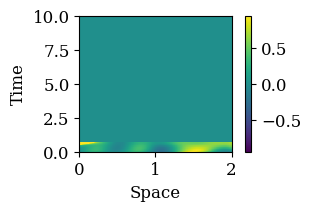

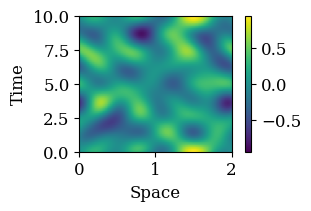

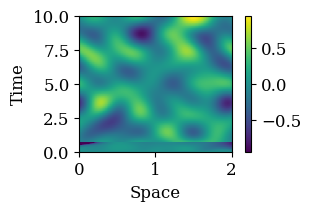

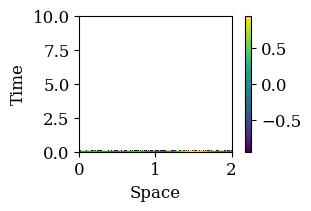

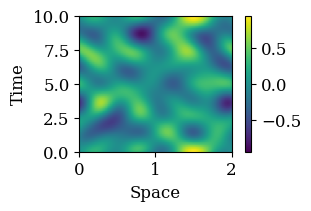

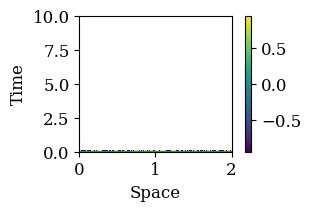

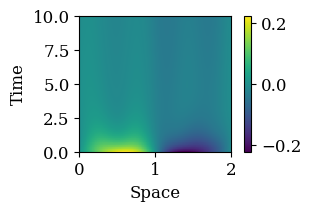

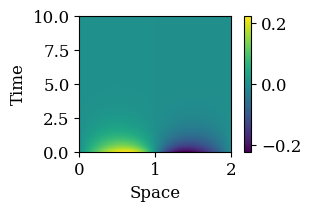

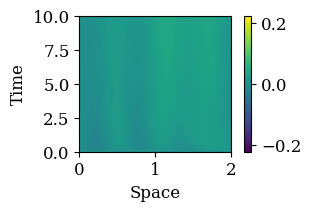

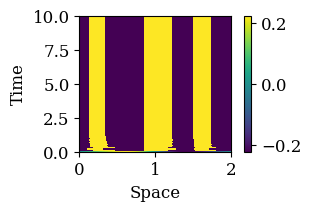

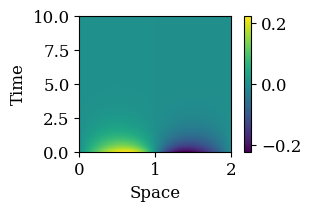

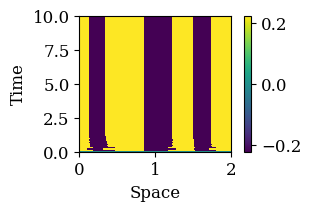

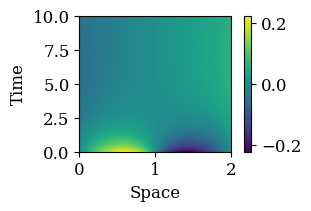

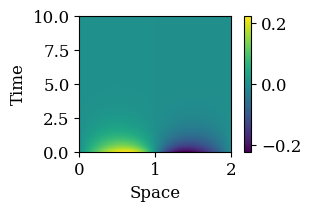

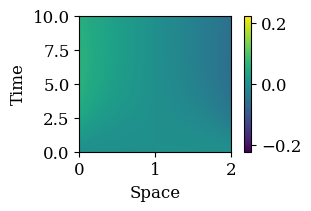

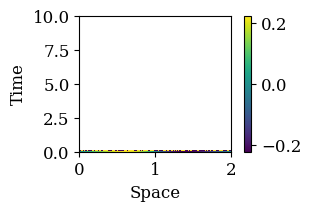

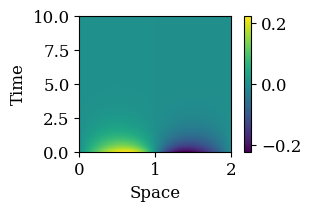

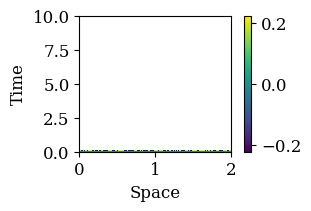

In [6]:
time_domain = slice(0.0, 10.0, 200)
space_domain = slice(0.0, 2.0, 400)
periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
problem = Burgers()
# nu = 0
# nu_values = [0.01]
nu_values = [0.0, 0.01, 0.1]
noise_level = 0.1
# noise_levels = [0.05, 0.1, 0.5]
c = 3.0  # constant of exact equation
n = 500
modes = (8, 8)
nt = 200
time_res = slice(time_domain.start, time_domain.stop, nt)
nx = 400
space_res = slice(space_domain.start, space_domain.stop, nx)
data_fig = []
data_ax = []
lssvr_function_results = {}
lssvr_spectral_results = {}
fnn_function_results = {}
fnn_spectral_results = {}
lssvr_rollout_function_results = {}
fnn_rollout_function_results = {}
spo_rollout_function_results = {}
tdo_rollout_function_results = {}
lssvr_exact_function_results = {}
fnn_exact_function_results = {}
spo_exact_function_results = {}
tdo_exact_function_results = {}
exact_function_results = {}
sigma_values = {}
scale_range = {}
for i, nu in enumerate(nu_values):
    label = f"{nu}"
    generator = torch.Generator().manual_seed(42)
    u_rand, f_rand = problem.generate(
        basis=FourierBasis,
        n=n,
        modes=modes,
        nu=nu,
        u0="random",
        f="random",
        generator=generator,
        time_domain=time_domain,
        space_domain=space_domain,
        time_dependent_coeff=False,
    )
    # for i, noise_level in enumerate(noise_levels):
    # label = f"{noise_level*100}%"

    # add noise
    u_noisy = u_rand.perturb(std_ratio=noise_level, generator=generator)
    f_noisy = f_rand.perturb(std_ratio=noise_level, generator=generator)

    # fig, ax = plt.subplots(figsize=(4, 3))
    # im = u_noisy.plot(i=-1, plt=ax)
    # fig.colorbar(im, ax=ax)
    # ax.set_ylabel("Time")
    # ax.set_xlabel("Space")
    # data_fig.append(fig)
    # data_ax.append(ax)
    # save_to_pgf(f"burgers_solution_{nu}.pgf", plt=fig)

    # fig, ax = plt.subplots(figsize=(4, 3))
    # im = f_noisy.plot(i=0, plt=ax)
    # fig.colorbar(im, ax=ax)
    # ax.set_ylabel("Time")
    # ax.set_xlabel("Space")
    # data_fig.append(fig)
    # data_ax.append(ax)
    # save_to_pgf(f"burgers_forcing_{nu}.pgf", plt=fig)

    # Split data by function sample
    n_train = int(0.8 * n)
    # n_train = n-4
    # Train data
    u_train, f_train, _ = get_function_values(
        u_noisy[:n_train],
        f_noisy[:n_train],
        res=(time_res, space_res),
        # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
    )
    uh_train, fh_train = get_time_dep_coeffs(u_train, f_train, target_modes=modes[1])
    uc_train, fc_train, uf_train = get_time_pairs(uh_train, fh_train)
    x_train, y_train = get_features_labels(
        uc_train,
        fc_train,
        uf_train,
        sample_size=8000,
        generator=generator,
    )
    # Test data
    u_test, f_test, grid = get_function_values(
        u_noisy[n_train:],
        f_noisy[n_train:],
        res=(time_res, space_res),
        # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
    )
    uh_test, fh_test = get_time_dep_coeffs(u_test, f_test, target_modes=modes[1])
    uc_test, fc_test, uf_test = get_time_pairs(uh_test, fh_test)
    x_test, y_test = get_features_labels(
        uc_test,
        fc_test,
        uf_test,
    )
    scale_range = {
        **scale_range,
        label: {
            "coeff": y_test.abs().flatten(1).max(1).values.mean().item(),
            "func": FourierBasis.inv_transform(y_test).real.max(1).values.mean().item(),
        },
    }

    # scale input data
    scaler = StandardScaler().fit(x_train)
    input_train = scaler.transform(x_train)
    output_train = y_train
    input_test = scaler.transform(x_test)
    output_test = y_test

    # test if the output is trivially computed from the inputs
    # previous_time_step = to_real_coeff(x_train[:, : y_train.shape[1]]).contiguous()
    # next_time_step = to_real_coeff(
    #     y_train[:]
    # ).contiguous()
    # data_metrics = {
    #     **data_metrics,
    #     nu_label: get_metrics(next_time_step, previous_time_step),
    # }
    # Training
    lssvr = SpectralSVR(
        FourierBasis(periods=space_domain.stop - space_domain.stop),
        regressor=LSSVR(C=1.0),
    )
    lssvr.train(input_train, output_train)
    test_results = lssvr.test(input_test, output_test)
    lssvr_function_results = {
        **lssvr_function_results,
        label: test_results["function value"],
    }
    lssvr_spectral_results = {
        **lssvr_spectral_results,
        label: test_results["spectral"],
    }
    fnn = SpectralSVR(
        FourierBasis(periods=space_domain.stop - space_domain.stop),
        regressor=FNN(MAX_EPOCH=7, batch_size=16, w_hidden=64, n_hidden=4),
    )
    fnn.train(input_train, output_train)
    test_results = fnn.test(input_test, output_test)
    fnn_function_results = {
        **fnn_function_results,
        label: test_results["function value"],
    }
    fnn_spectral_results = {
        **fnn_spectral_results,
        label: test_results["spectral"],
    }
    # rollout testing
    u_lssvr = get_model_rollout(
        lssvr,
        uh_test[:, 0],  # first time step coeffs
        fh_test,
        space_res,
        spatial_period=u_noisy.periods[1],
        scaler=scaler,
    )
    lssvr_metrics = plot_rollout(
        u_lssvr,
        u_test,
        nu,
        time_res,
        space_res,
        label="rollout_lssvr",
        n=-1,
    )
    lssvr_rollout_function_results = {
        **lssvr_rollout_function_results,
        label: lssvr_metrics,
    }
    u_fnn = get_model_rollout(
        fnn,
        uh_test[:, 0],  # first time step coeffs
        fh_test,
        space_res,
        spatial_period=u_noisy.periods[1],
        scaler=scaler,
    )
    fnn_metrics = plot_rollout(
        u_fnn,
        u_test,
        nu,
        time_res,
        space_res,
        label="rollout_fnn",
        n=-1,
    )
    fnn_rollout_function_results = {
        **fnn_rollout_function_results,
        label: fnn_metrics,
    }
    # setup grid for odeint
    dx = grid[0, 1, 1].sub(grid[0, 0, 1]).item()
    tt = grid[:, 0, 0]
    u_spo = get_spo_rollout(
        u_test[-1:, 0],
        f_noisy[-1:],
        nu,
        tt,
        space_res=space_res,
    )
    spo_metrics = plot_rollout(
        u_spo,
        u_test[-1:],
        nu,
        time_res,
        space_res,
        label="rollout_spo",
        n=-1,
    )
    spo_rollout_function_results = {
        **spo_rollout_function_results,
        label: spo_metrics,
    }

    u_tdo = get_tdo_rollout(
        u_test[-1:, 0],
        f_noisy[-1:],
        nu,
        tt,
        space_res=space_res,
    )
    tdo_metrics = plot_rollout(
        u_tdo,
        u_test[-1:],
        nu,
        time_res,
        space_res,
        label="rollout_tdo",
        n=-1,
    )
    tdo_rollout_function_results = {
        **tdo_rollout_function_results,
        label: tdo_metrics,
    }
    # exact rollout
    u_e = u_exact(grid[0, :, 1], grid[:, 0, 0], nu=nu, c=c).unsqueeze(0)
    f_basis = FourierBasis.generate(1, modes=modes, value_type="zero")
    uh_exact = resize_modes(
        FourierBasis.transform(u_e.flatten(0, 1)), target_modes=8
    ).unsqueeze(0)
    fh_exact = resize_modes(
        FourierBasis.transform(
            f_basis.get_values(res=(time_res, space_res)).real.flatten(0, 1)
        ),
        target_modes=8,
    ).unsqueeze(0)
    u_lssvr = get_model_rollout(
        lssvr,
        uh_exact[:, 0],  # first time step coeffs
        fh_exact,
        space_res,
        spatial_period=u_noisy.periods[1],
        scaler=scaler,
    )
    lssvr_metrics = plot_rollout(
        u_lssvr,
        u_e,
        nu,
        time_res,
        space_res,
        label="exact_lssvr",
        n=-1,
    )
    lssvr_exact_function_results = {
        **lssvr_exact_function_results,
        label: lssvr_metrics,
    }
    u_fnn = get_model_rollout(
        fnn,
        uh_exact[:, 0],  # first time step coeffs
        fh_exact,
        space_res,
        spatial_period=u_noisy.periods[1],
        scaler=scaler,
    )
    fnn_metrics = plot_rollout(
        u_fnn,
        u_e,
        nu,
        time_res,
        space_res,
        label="exact_fnn",
        n=-1,
    )
    fnn_exact_function_results = {
        **fnn_exact_function_results,
        label: fnn_metrics,
    }
    # setup grid for odeint
    dx = grid[0, 1, 1].sub(grid[0, 0, 1]).item()
    tt = grid[:, 0, 0]
    u_spo = get_spo_rollout(
        u_e[:, 0],
        f_basis,
        nu,
        tt,
        space_res=space_res,
    )

    spo_metrics = plot_rollout(
        u_spo,
        u_e,
        nu,
        time_res,
        space_res,
        label="exact_spo",
        n=-1,
    )
    spo_exact_function_results = {
        **spo_exact_function_results,
        label: spo_metrics,
    }

    u_tdo = get_tdo_rollout(
        u_e[:, 0],
        f_basis,
        nu,
        tt,
        space_res=space_res,
    )

    tdo_metrics = plot_rollout(
        u_tdo,
        u_e,
        nu,
        time_res,
        space_res,
        label="exact_tdo",
        n=-1,
    )
    tdo_exact_function_results = {
        **tdo_exact_function_results,
        label: tdo_metrics,
    }

In [7]:
fnn_function_results

{'0.0': {'mse': 7.488454866688699e-05,
  'rmse': 0.00865358579903841,
  'mae': 0.006799216847866774,
  'r2': 0.7749285697937012,
  'smape': 0.7583128213882446,
  'rse': 0.22507144510746002,
  'rrse': 0.4740460216999054,
  'pred_nan_sum': 0},
 '0.01': {'mse': 7.510255818488076e-05,
  'rmse': 0.008666173554956913,
  'mae': 0.006826762109994888,
  'r2': 0.7741828560829163,
  'smape': 0.7620357871055603,
  'rse': 0.22581711411476135,
  'rrse': 0.4748455882072449,
  'pred_nan_sum': 0},
 '0.1': {'mse': 0.0001775274722604081,
  'rmse': 0.013323943130671978,
  'mae': 0.010595464147627354,
  'r2': 0.46573179960250854,
  'smape': 1.0439156293869019,
  'rse': 0.5342682003974915,
  'rrse': 0.7299463152885437,
  'pred_nan_sum': 0}}

In [8]:
lssvr_function_results

{'0.0': {'mse': 7.566920248791575e-05,
  'rmse': 0.008698804304003716,
  'mae': 0.00684097595512867,
  'r2': 0.7725250124931335,
  'smape': 0.7629085779190063,
  'rse': 0.22747498750686646,
  'rrse': 0.47666653990745544,
  'pred_nan_sum': 0},
 '0.01': {'mse': 7.874613220337778e-05,
  'rmse': 0.008873901329934597,
  'mae': 0.006978868506848812,
  'r2': 0.763367235660553,
  'smape': 0.7750269770622253,
  'rse': 0.2366327941417694,
  'rrse': 0.4861838221549988,
  'pred_nan_sum': 0},
 '0.1': {'mse': 0.0001755633857101202,
  'rmse': 0.013250033371150494,
  'mae': 0.010524891316890717,
  'r2': 0.4722108840942383,
  'smape': 1.0652414560317993,
  'rse': 0.5277891159057617,
  'rrse': 0.7259930968284607,
  'pred_nan_sum': 0}}

In [32]:
u_e = u_exact(grid[0, :, 1], grid[:, 0, 0], nu=nu, c=c).unsqueeze(0)
f_basis = FourierBasis.generate(1, modes=modes, value_type="zero")
uh_exact = resize_modes(
    FourierBasis.transform(u_e.flatten(0, 1)), target_modes=8
).unsqueeze(0)
fh_exact = resize_modes(
    FourierBasis.transform(
        f_basis.get_values(res=(time_res, space_res)).real.flatten(0, 1)
    ),
    target_modes=8,
).unsqueeze(0)
dx = grid[0, 1, 1].sub(grid[0, 0, 1]).item()
tt = grid[:, 0, 0]

In [11]:
%timeit lssvr.train(input_train, output_train)

8 s ± 2.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit fnn.train(input_train, output_train)

14.6 s ± 865 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit get_model_rollout(lssvr, uh_exact[:, 0],  fh_exact, space_res, spatial_period=u_noisy.periods[1], scaler=scaler)

438 ms ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit get_model_rollout(fnn, uh_exact[:, 0],  fh_exact, space_res, spatial_period=u_noisy.periods[1], scaler=scaler)

298 ms ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit get_spo_rollout(u_e[:, 0], f_basis, nu, tt, space_res=space_res,)

15.1 s ± 2.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit get_tdo_rollout(u_e[:, 0], f_basis, nu, tt, space_res=space_res,)

c:\Users\ahmad\AppData\Local\pypoetry\Cache\virtualenvs\skripsi-program-7DNU0s2h-py3.10\lib\site-packages\torchdiffeq\_impl\fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


20.9 s ± 2.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
pd.DataFrame(lssvr_rollout_function_results).T.style.format(
    precision=2#, formatter="{:.2e}".format
).to_latex("tmp.tex")


In [17]:
pd.DataFrame(fnn_rollout_function_results).T.style.format(
    precision=2#, formatter="{:.2e}".format
).to_latex("tmp.tex")


In [11]:
pd.DataFrame(spo_rollout_function_results).T.style.format(
     precision=2, #formatter="{:.2e}".format
).to_latex("tmp.tex")


In [12]:
pd.DataFrame(tdo_rollout_function_results).T.style.format(
     precision=2, #formatter="{:.2e}".format
).to_latex("tmp.tex")


,mse,rmse,mae,r2,smape,rse,rrse,pred_nan_sum
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156758.000000
0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157600.000000
0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157600.000000


In [9]:
pd.DataFrame(scale_range).T

,coeff,func
0.0,0.07733,0.025438
0.01,0.07733,0.025438
0.1,0.07733,0.025438


In [18]:
pd.DataFrame(lssvr_exact_function_results).T.style.format(
    precision=2#, formatter="{:.2e}".format
).to_latex("tmp.tex")

In [19]:

pd.DataFrame(fnn_exact_function_results).T.style.format(
    precision=2#, formatter="{:.2e}".format
).to_latex("tmp.tex")

In [41]:
pd.DataFrame(spo_exact_function_results).T.style.format(
     precision=2, #formatter="{:.2e}".format
).to_latex("tmp.tex")


In [42]:
pd.DataFrame(tdo_exact_function_results).T.style.format(
     precision=2, #formatter="{:.2e}".format
).to_latex("tmp.tex")


In [26]:
# data_results_df = pd.DataFrame(data_metrics).T
# data_results_df.index.name="\(\nu \)"
# data_results_df.style.format(precision=2)#.to_latex("tmp.tex")

In [32]:
rollout_spectral_results_df = pd.DataFrame(rollout_spectral_results).T
rollout_spectral_results_df.index.name = "\(\nu \)"
rollout_spectral_results_df.style.format(precision=2).to_latex(
# rollout_spectral_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [30]:
rollout_function_results_df = pd.DataFrame(lssvr_rollout_function_results).T
rollout_function_results_df.index.name = "\(\nu \)"
# rollout_function_results_df.style.format(precision=2).to_latex(
rollout_function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [33]:
exact_spectral_results_df = pd.DataFrame(exact_spectral_results).T
exact_spectral_results_df.index.name = "\(\nu \)"
# exact_spectral_results_df.style.format(precision=2).to_latex(
exact_spectral_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)

In [34]:
exact_function_results_df = pd.DataFrame(exact_function_results).T
exact_function_results_df.index.name = "\(\nu \)"
# exact_function_results_df.style.format(precision=2).to_latex(
exact_function_results_df.style.format(precision=2, formatter="{:.2e}".format).to_latex(
    "tmp.tex"
)